#### Import of useful libraries

In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.ndimage import binary_erosion
from skimage import morphology
import skimage.morphology as morpho

from skimage.measure import regionprops, find_contours
import itertools


# Data exploitation

### Loading Data

In [2]:
def load_nifti(file_path):
    """    
    Input: NIfTI data path
    Output: data converted to NumPy and header
    """
    nii = nib.load(file_path)
    data = nii.get_fdata()
    header = nii.header
    return data, header

In [3]:
def compute_voxel_volume(header):
    """
    Input: header's NIfTI data
    Output: voxel volume in mL
    """
    zooms = header.get_zooms()#[:3]  # get spatial dimensions (dx, dy, dz)
    vol_mm3 = np.prod(zooms) # header's zooms in millimeters
    vol_ml = vol_mm3 / 1000.0 # (1 mL = 1000 mm^3)
    return vol_ml

def compute_label_volume(segmentation, label, voxel_vol):
    """
    Input: Segmentation, label to compute the volume, voxel volume
    Output: Volume (in mL) of the given label in the segmentation map.
    """
    voxel_count = np.sum(segmentation == label)
    return voxel_count * voxel_vol

In [5]:
# set data paths
dataSet_path = "./Dataset/"
train_folder = dataSet_path + "Train/"
test_folder = dataSet_path + "Test/"

metadata_train_path = dataSet_path + "metaDataTrain.csv"
metadata_submissiontest_path = dataSet_path + "metaDataTest.csv"

In [6]:
# Loading data
metadata_train = pd.read_csv(metadata_train_path)
metadata_submissiontest = pd.read_csv(metadata_submissiontest_path)
sample = pd.read_csv(dataSet_path + "SampleSubmission.csv")

In [7]:
# analyse metadata content
metadata_train.head()

,Id,Category,Height,Weight
0,1,2,184.0,95.0
1,2,2,160.0,70.0
2,3,2,165.0,77.0
3,4,2,159.0,46.0
4,5,2,165.0,77.0


In [8]:
metadata_train[metadata_train['Id'] == 2].iloc[0]

Id            2.0
Category      2.0
Height      160.0
Weight       70.0
Name: 1, dtype: float64

In [9]:
a = metadata_train['Id'].astype(str).tolist()

In [10]:
str(a[0]).zfill(3)

'001'

In [11]:
metadata_submissiontest.head()

,Id,Height,Weight
0,101,170.0,70.0
1,102,162.0,60.0
2,103,185.0,104.0
3,104,158.0,56.0
4,105,164.0,64.0


In [12]:
sample.head()

,Id,Category
0,101,0
1,102,0
2,103,0
3,104,0
4,105,0


In [13]:
im, header = load_nifti(train_folder + "001/" + "001_ED.nii")

im.shape

(216, 256, 10)

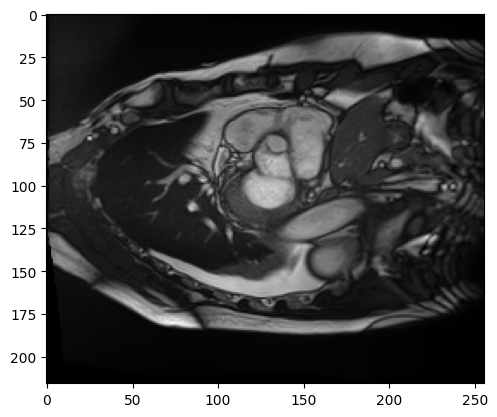

In [14]:
plt.imshow(im[:,:,0], cmap="gray")
plt.show()

In [15]:
compute_voxel_volume(header)

np.float32(0.024414062)

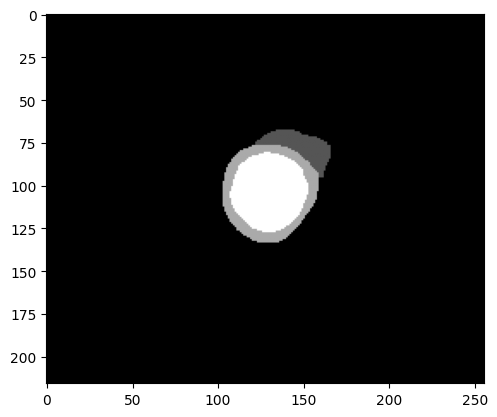

In [16]:
im_seg, header = load_nifti(train_folder + "001/" + "001_ED_seg.nii")

plt.imshow(im_seg[:,:,5], cmap="gray")
plt.show()

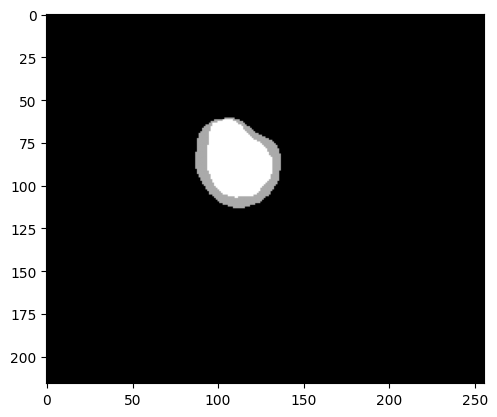

In [17]:
im_seg2, header = load_nifti(train_folder + "011/" + "011_ED_seg.nii")

plt.imshow(im_seg2[:,:,0], cmap="gray")
plt.show()

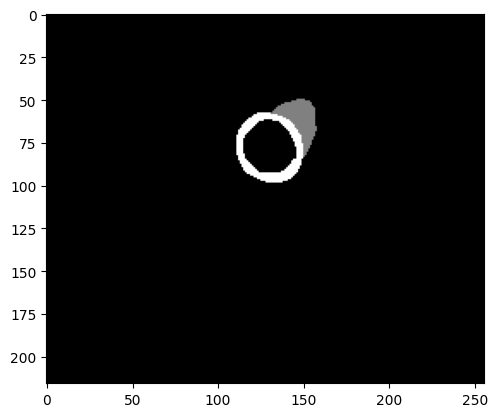

In [18]:
im_seg_test, header = load_nifti(test_folder + "101/" + "101_ED_seg.nii")

plt.imshow(im_seg_test[:,:,5], cmap="gray")
plt.show()

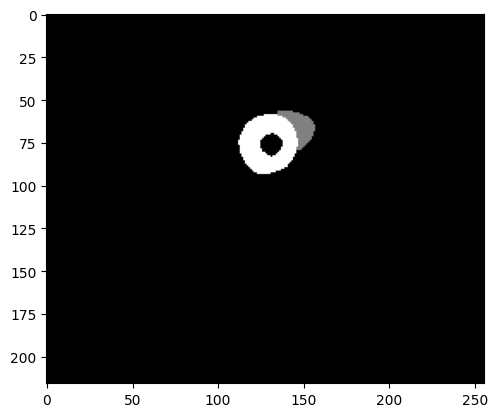

In [19]:
im_seg_test, header = load_nifti(test_folder + "101/" + "101_ES_seg.nii")

plt.imshow(im_seg_test[:,:,5], cmap="gray")
plt.show()

In [20]:
def plot_slices_grid(visualizations, base_path):
    # Create grid layout (2 rows x 4 columns for 7 images + 1 empty)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.ravel()  # Flatten the axis array
    
    for idx, viz in enumerate(visualizations):
        # Construct file path
        seg_path = os.path.join(
            base_path,
            f"{viz['subject']}/",
            f"{viz['subject']}_{viz['phase']}_seg.nii"
        )
        
        # Load segmentation
        seg_img = nib.load(seg_path).get_fdata()
        
        # Plot in grid
        ax = axs[idx]
        ax.imshow(seg_img[:, :, viz['slice']], cmap="gray")
        ax.set_title(f"Subj {viz['subject']} {viz['phase']} Slice {viz['slice']}", fontsize=10)
        ax.axis('off')
    
    # Hide empty subplot
    axs[-1].axis('off')
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [21]:
# Opend myocard segmentations
visualizations = [
    {"subject": "011", "phase": "ED", "slice": 0},
    {"subject": "029", "phase": "ED", "slice": 0},
    {"subject": "045", "phase": "ES", "slice": 0},
    {"subject": "068", "phase": "ES", "slice": 0},
    {"subject": "069", "phase": "ES", "slice": 0},
    {"subject": "084", "phase": "ES", "slice": 0},
    {"subject": "096", "phase": "ES", "slice": 1}
]

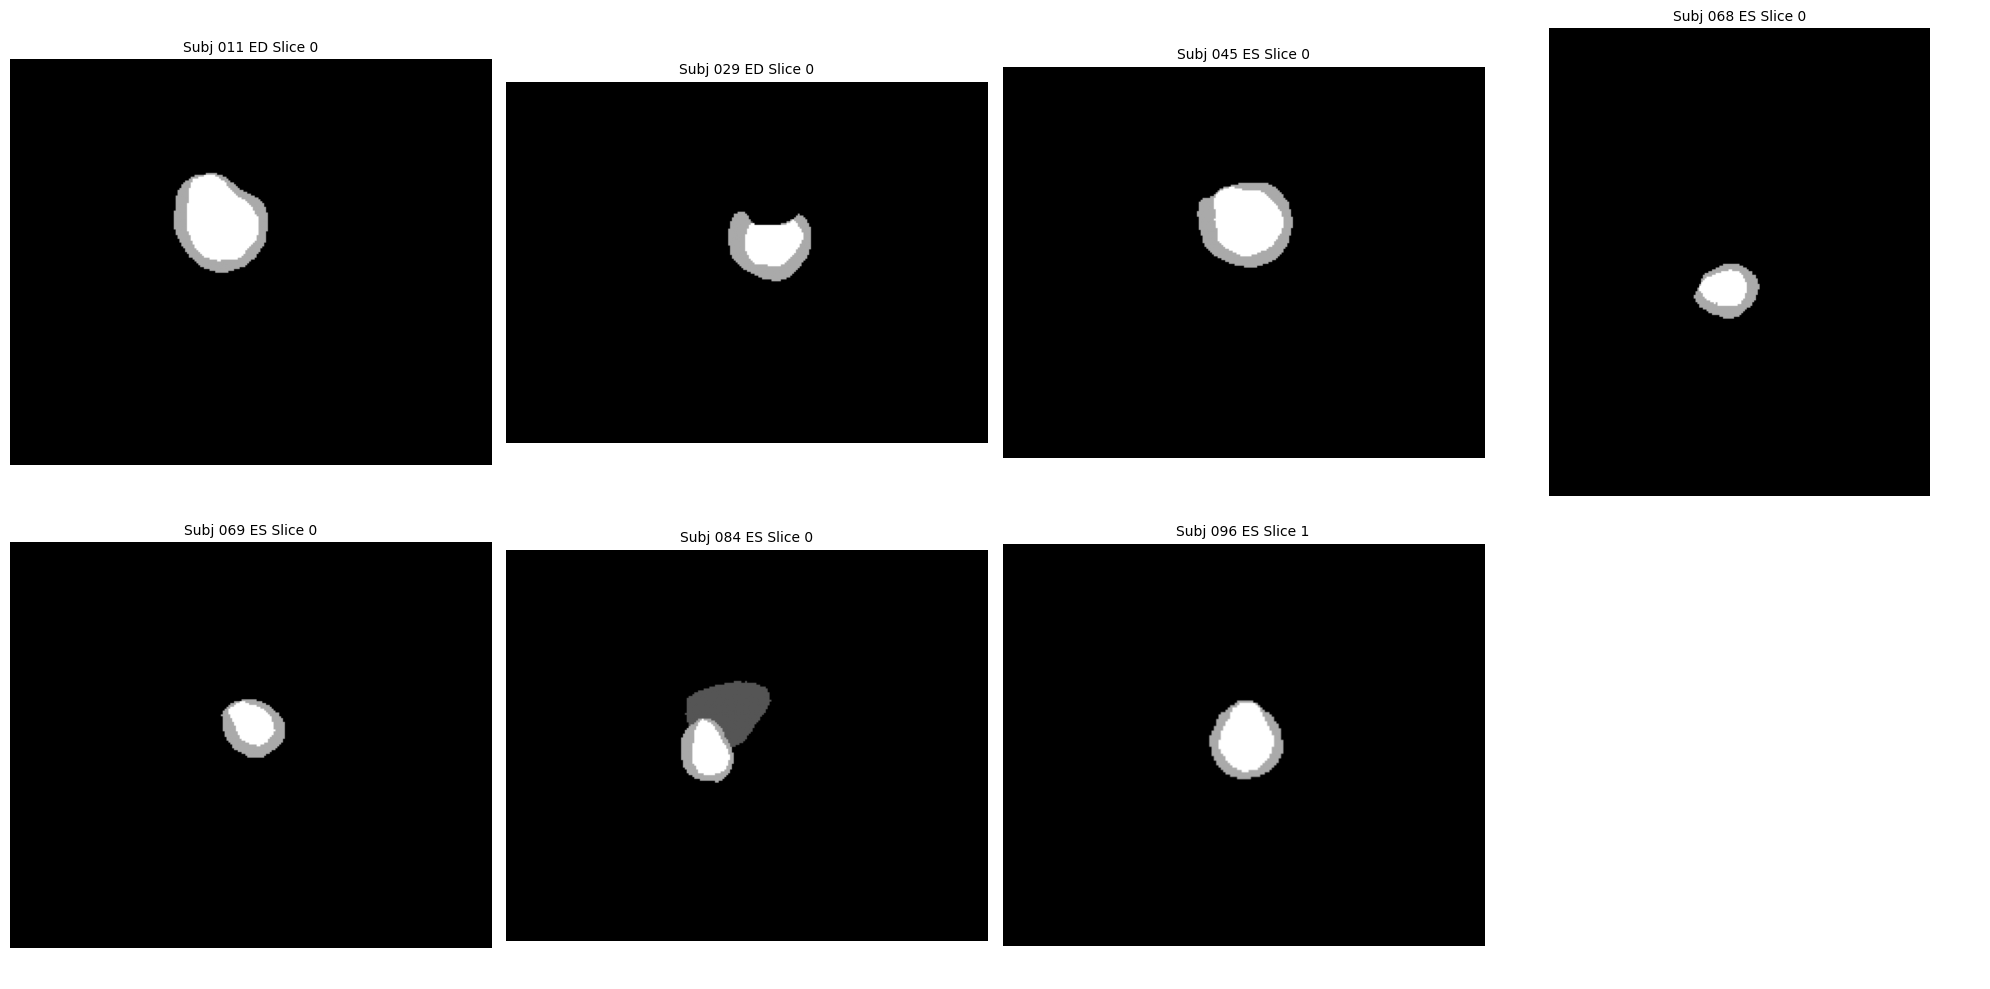

In [22]:
plot_slices_grid(visualizations, train_folder)

## Segmentation

In [23]:
def remove_left_ventricle(segmentation_array):
    """
    Removes left ventricle (label 3) from segmentation map.
    
    Args:
        segmentation_array (np.ndarray): Input segmentation array with labels:
                                         1 = RV, 2 = Myocardium, 3 = LV
                                         
    Returns:
        np.ndarray: Segmentation array with LV removed (LV voxels set to 0)
    """
    cleaned_seg = segmentation_array.copy()
    cleaned_seg[cleaned_seg == 3] = 0  # Remove LV
    cleaned_seg = cleaned_seg.astype(np.uint8)
    return cleaned_seg

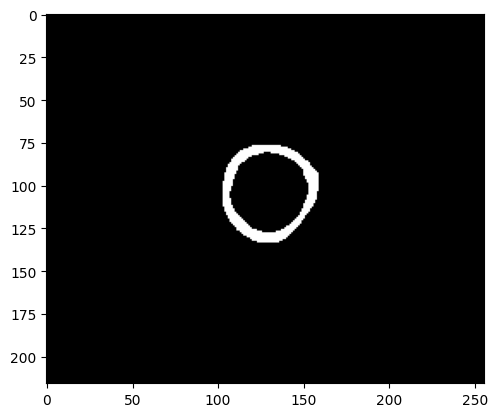

In [24]:
im_seg[:,:,5] == 1
plt.imshow(im_seg[:,:,5]==2, cmap="gray")
plt.show()

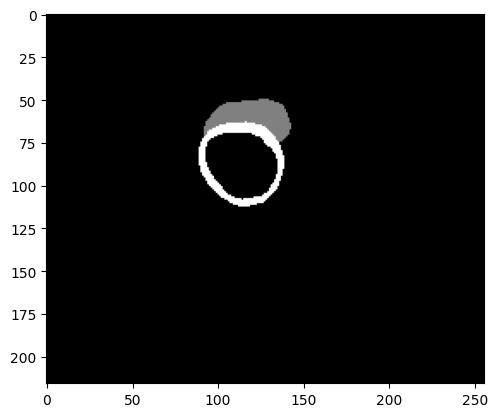

In [25]:
no_lv_im_seg = remove_left_ventricle(im_seg2)
plt.imshow(no_lv_im_seg[:,:,5], cmap="gray")
plt.show()

In [26]:
# take only the myocard to treat
myo_mask = (no_lv_im_seg == 2).astype(np.uint8)

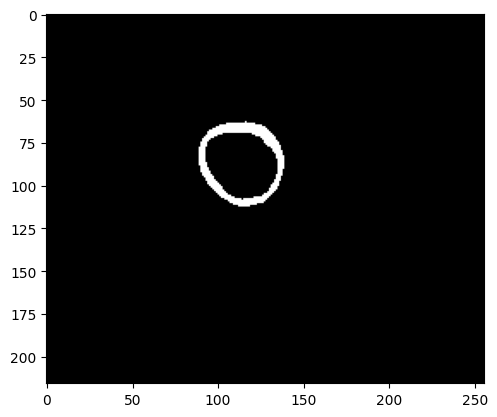

In [27]:
plt.imshow(myo_mask[:,:,5], cmap="gray")
plt.show()

In [28]:
def radius_value(mask_slice):
    """
    Input:
    Output:
    """
    
    props = regionprops(mask_slice)
    cy, cx = props[0].centroid
    
    contours = find_contours(mask_slice, level=0.5)
    boundary_points = np.vstack(contours)
    
    distances = np.linalg.norm(boundary_points - np.array((cy, cx)), axis=1)
    
    mean_radius = np.mean(distances)
    max_radius = np.max(distances)
    min_radius = np.min(distances)

    return max_radius, min_radius, mean_radius
    

In [29]:
def slice_seg_lv(segmentation_slice):
    """
    Input: segmentation 
    Output: 
    """
    myo_mask = (segmentation_slice == 2).astype(np.uint8)
    max_radius, min_radius, mean_radius = radius_value(myo_mask)

    full = morphology.closing(myo_mask, morphology.disk(max_radius))

    seg_lv = full - myo_mask

    return seg_lv
    

In [30]:
def add_new_segmentation(original_seg, new_mask, label_value=4, conflict_strategy='preserve_existing'):
    """
    Add a new segmentation label to an existing segmentation array
    
    Args:
        original_seg (np.ndarray): 3D array with existing labels (1-3)
        new_mask (np.ndarray): Binary mask for new segmentation (same shape)
        label_value (int): Value to use for new label (default=4)
        conflict_strategy: How to handle overlaps:
            'preserve_existing' - keep original labels (default)
            'overwrite' - prioritize new label
    
    Returns:
        np.ndarray: Updated segmentation with new label
    """
    # Validate inputs
    assert original_seg.shape == new_mask.shape, "Shapes must match"
    assert label_value not in np.unique(original_seg), "Label value already exists"
    
    # Create copy of original segmentation
    modified_seg = original_seg.copy()
    
    # Handle conflicts based on strategy
    if conflict_strategy == 'preserve_existing':
        # Only add new label where background exists
        modified_seg[(new_mask > 0) & (original_seg == 0)] = label_value
    elif conflict_strategy == 'overwrite':
        # Override existing labels in mask area
        modified_seg[new_mask > 0] = label_value
    else:
        raise ValueError("Invalid conflict strategy")
    
    return modified_seg

In [31]:
def segmentation(original_segmentation,redo=False):
    """
    Input: segmentation_without lv
    Output: segmentation with lv
    """
    segmentation = original_segmentation
    if redo:
        segmentation = remove_left_ventricle(original_segmentation)
    
    # verify if lv segmentation existis
    if np.sum(segmentation == 3) != 0:
        return original_segmentation
    
    new_seg = original_segmentation
    for z in range(segmentation.shape[2]):
        slice_2d = segmentation[:, :, z]
        if np.sum(slice_2d == 2) == 0: # verify if there is a myocard mask
            continue
        seg_lv = slice_seg_lv(slice_2d)
        new_seg[:, :, z] = add_new_segmentation(slice_2d, seg_lv, label_value=3, conflict_strategy='preserve_existing')

    return new_seg

In [32]:
def calculate_iou(original_seg, new_seg):
    """
    Calculates Intersection over Union (IoU) for each label between two segmentation arrays.

    Args:
        original_seg (np.ndarray): Original segmentation array.
        new_seg (np.ndarray): New segmentation array to compare.

    Returns:
        dict: A dictionary where keys are label values and values are IoU scores.
    """
    assert original_seg.shape == new_seg.shape, "Segmentation arrays must have the same shape"
    
    # Get all unique labels from both segmentations
    original_labels = np.unique(original_seg)
    new_labels = np.unique(new_seg)
    all_labels = np.union1d(original_labels, new_labels)
    
    iou_scores = {}
    
    for label in all_labels:
        # Create masks for the current label
        mask_original = (original_seg == label)
        mask_new = (new_seg == label)
        
        # Calculate intersection and union
        intersection = np.logical_and(mask_original, mask_new).sum()
        union = np.logical_or(mask_original, mask_new).sum()
        
        # Handle case where union is zero (both masks are empty)
        if union == 0:
            iou = 1.0  # No elements present in both, so perfect agreement
        else:
            iou = intersection / union
        
        iou_scores[label] = iou
    
    return iou_scores

### Test on problematic exemple

In [33]:
im_seg_prob, header = load_nifti(train_folder + "029/" + "029_ED_seg.nii")
# {"subject": "029", "phase": "ED", "slice": 0},
no_lv_im_seg_prob = remove_left_ventricle(im_seg_prob)

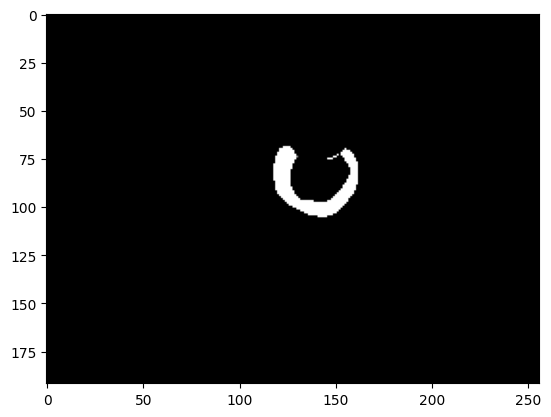

In [34]:
plt.imshow(no_lv_im_seg_prob[:,:,0], cmap="gray")
plt.show()

In [35]:
prob_slice = no_lv_im_seg_prob[:,:,0]

In [36]:
lv_prob = slice_seg_lv(prob_slice)

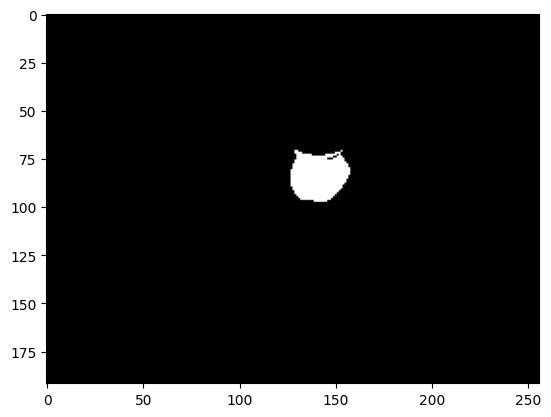

In [37]:
plt.imshow(lv_prob, cmap="gray")
plt.show()

In [38]:
new_prob_seg = add_new_segmentation(prob_slice, lv_prob, label_value=4, conflict_strategy='preserve_existing')

In [39]:
new_seg = segmentation(no_lv_im_seg_prob)

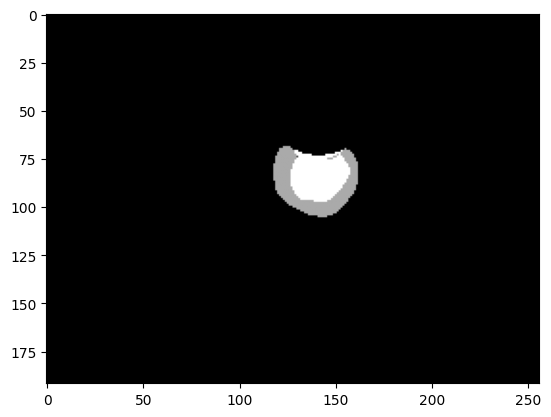

In [40]:
plt.imshow(new_seg[:,:,0], cmap="gray")
plt.show()

In [41]:
im_segtest_prob, header = load_nifti(test_folder + "102/" + "102_ED_seg.nii")

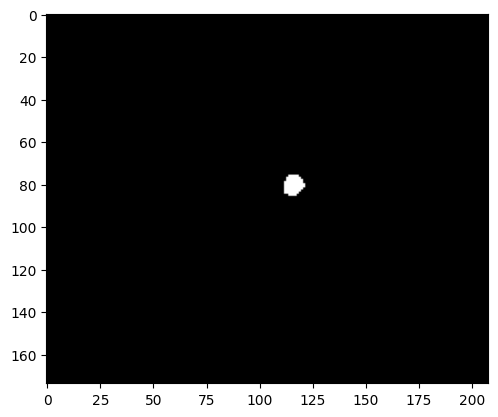

In [42]:
plt.imshow(im_segtest_prob[:,:,16], cmap="gray")
plt.show()

In [43]:
prob_testslice = im_segtest_prob[:,:,16]

In [44]:
np.unique(prob_testslice)

array([0., 1.])

In [45]:
np.sum(prob_testslice == 2) == 0

np.True_

In [46]:
im_seg_prob[im_seg_prob == 3].astype(np.uint8)

array([3, 3, 3, ..., 3, 3, 3], dtype=uint8)

In [47]:
lv_prob

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [48]:
#calculate_iou(original_seg=im_seg_prob[im_seg_prob == 3].astype(np.uint8), new_seg=lv_prob)

In [49]:
def calculate_mean_lv_iou(original_segmentations):
    """
    Calculates mean IoU for LV (label 3) across 100 samples after re-segmentation.
    
    Args:
        original_segmentations (list of np.ndarray): List of 100 original segmentation arrays
        
    Returns:
        float: Mean IoU score for LV across all samples
    """
    total_iou = 0.0
    n_samples = len(original_segmentations)
    
    for original_seg in original_segmentations:
        # Remove LV and regenerate it
        cleaned_seg = remove_left_ventricle(original_seg)
        new_seg = segmentation(cleaned_seg)
        
        # Calculate IoU specifically for LV
        iou_dict = calculate_iou(original_seg, new_seg)
        total_iou += iou_dict.get(3, 0.0)  # Use 0 if LV missing in new segmentation
    
    return total_iou / n_samples

In [50]:
# for idx in range():
#     idx = str(idx).zfill(3)
#     subject = load_subject_data(metadata_train, train_folder , idx)
    

In [51]:
#subject01 = load_subject_data(metadata_train, train_folder , "001")

## Feature extraction

In [52]:
def load_subject_data(metadata, subject_folder:str, subject_id:str, redo_lv=False):
    """
    Input: metadata, data folder, subject
    Output: dictionary with the image and segmentation data.
    """
    
    # file paths
    ed_path = glob.glob(os.path.join(subject_folder, subject_id+"/", f"{subject_id}_ED.nii"))[0]
    ed_seg_path = glob.glob(os.path.join(subject_folder, subject_id+"/", f"{subject_id}_ED_seg.nii"))[0]
    es_path = glob.glob(os.path.join(subject_folder, subject_id+"/", f"{subject_id}_ES.nii"))[0]
    es_seg_path = glob.glob(os.path.join(subject_folder, subject_id+"/", f"{subject_id}_ES_seg.nii"))[0]

    # loads data
    ed_image, header= load_nifti(ed_path)
    ed_seg,_= load_nifti(ed_seg_path)
    es_image,_= load_nifti(es_path)
    es_seg,_= load_nifti(es_seg_path)

    # Segment LV if necessary
    ed_seg = segmentation(ed_seg,redo=redo_lv)
    es_seg = segmentation(es_seg,redo=redo_lv)
    
    # retrives metadata
    row = metadata[metadata['Id'] == int(subject_id)].iloc[0]
    weight = float(row["Weight"])
    height = float(row["Height"])

    vol = compute_voxel_volume(header)
    
    subject_data = {
        "ED_image": ed_image,
        "ED_seg": ed_seg,
        "ES_image": es_image,
        "ES_seg": es_seg,
        "Weight": weight,
        "Height": height,
        "voxel_vol":vol
    }
    return subject_data


In [53]:
import numpy as np
import SimpleITK as sitk
from scipy.ndimage import distance_transform_edt

In [54]:
def calculate_myo_thickness(ed_seg: np.ndarray, voxel_spacing: tuple) -> dict:
    """
    Calculate myocardial thickness from 3D segmentation using distance transforms.
    
    Args:
        ed_seg: 3D array with labels (0=background, 1=RV, 2=Myo, 3=LV)
        voxel_spacing: Physical spacing of voxels in mm (z,y,x)
        
    Returns:
        Dictionary with thickness metrics (in millimeters)
    """
    try:
        # Create binary masks
        lv_mask = (ed_seg == 3).astype(np.uint8)      # Endocardium (LV)
        epi_mask = ((ed_seg == 2) | (ed_seg == 3))    # Epicardium (LV + Myo)
        myo_mask = (ed_seg == 2).astype(np.uint8)     # Myocardium

        # Compute distance transforms
        endo_dist = distance_transform_edt(lv_mask, sampling=voxel_spacing)
        epi_dist = distance_transform_edt(1 - epi_mask, sampling=voxel_spacing)

        # Calculate thickness map (endo to epi distance through myo)
        thickness_map = endo_dist + epi_dist
        thickness_map[myo_mask == 0] = 0  # Mask non-myocardial areas

        # Extract metrics
        myo_voxels = thickness_map[myo_mask > 0]
        if len(myo_voxels) == 0:
            return {k: np.nan for k in ['mean', 'max', 'min', 'std', 'median']}
            
        return {
            'mean': np.mean(myo_voxels),
            'max': np.max(myo_voxels),
            'min': np.min(myo_voxels),
            'std': np.std(myo_voxels),
            'median': np.median(myo_voxels)
        }
    except:
        return {k: np.nan for k in ['mean', 'max', 'min', 'std', 'median']}

In [55]:
def extract_features(subject_data:dict):
    """    
    Output: Dictionary with computed features.
    """
    voxel_vol = subject_data["voxel_vol"]
    # Label definitions: 1 = RV, 2 = Myocardium, 3 = LV
    ED_seg = subject_data["ED_seg"]
    ES_seg = subject_data["ES_seg"]
    
    features = {}
    # Compute volume for each structure in ED phase
    features["RV_vol_ED"] = compute_label_volume(ED_seg, 1, voxel_vol)
    features["MYO_vol_ED"] = compute_label_volume(ED_seg, 2, voxel_vol)
    features["LV_vol_ED"] = compute_label_volume(ED_seg, 3, voxel_vol)
    
    # Compute volume for each structure in ES phase
    features["RV_vol_ES"] = compute_label_volume(ES_seg, 1, voxel_vol)
    features["MYO_vol_ES"] = compute_label_volume(ES_seg, 2, voxel_vol)
    features["LV_vol_ES"] = compute_label_volume(ES_seg, 3, voxel_vol)
    
    # Compute left ventricle ejection fraction (EF) if volume at ED is positive
    if features["LV_vol_ED"] > 0:
        features["LV_EF"] = (features["LV_vol_ED"] - features["LV_vol_ES"]) / features["LV_vol_ED"]
    else:
        features["LV_EF"] = np.nan

    # Compute right ventricle ejection fraction (EF) if volume at ED is positive
    if features["RV_vol_ED"] > 0:
        features["RV_EF"] = (features["RV_vol_ED"] - features["RV_vol_ES"]) / features["RV_vol_ED"]
    else:
        features["RV_EF"] = np.nan

    # Compute myocardial thickness (ED phase only)
    try:
        # Calculate voxel spacing from voxel volume (assuming isotropic voxels)
        voxel_spacing = (voxel_vol ** (1/3),) * 3  # Convert volume to (z,y,x) spacing
        thickness = calculate_myo_thickness(ED_seg, voxel_spacing)
        features.update({
            "MYO_mean_thickness_ED": thickness['mean'],
            "MYO_max_thickness_ED": thickness['max'],
            "MYO_min_thickness_ED": thickness['min'],
            "MYO_std_thickness_ED": thickness['std'],
            "MYO_median_thickness_ED": thickness['median']
        })
    except:
        features.update({
            "MYO_mean_thickness_ED": np.nan,
            "MYO_max_thickness_ED": np.nan,
            "MYO_min_thickness_ED": np.nan,
            "MYO_std_thickness_ED": np.nan,
            "MYO_median_thickness_ED": np.nan
        })
    

    # Volume ratio 
    if features["LV_vol_ED"] != 0 and features["LV_vol_ES"] != 0:
        features["RV_LV_ED"]  = features["RV_vol_ED"]  / features["LV_vol_ED"]
        features["RV_LV_ES"]  = features["RV_vol_ES"]  / features["LV_vol_ES"]
        features["MYO_LV_ED"] = features["MYO_vol_ED"] / features["LV_vol_ED"]
        features["MYO_LV_ES"] = features["MYO_vol_ES"] / features["LV_vol_ES"]
    else:
        features["RV_LV_ED"]  = np.nan
        features["RV_LV_ES"]  = np.nan
        features["MYO_LV_ED"] = np.nan
        features["MYO_LV_ES"] = np.nan

    if "Weight" in subject_data and "Height" in subject_data:
        weight = subject_data["Weight"]
        height_m = subject_data["Height"]
        
        if height_m > 0 and weight > 0:
            # BMI calculation
            features["BMI"] = round(weight / (height_m ** 2), 2)
            
            # BSA calculation (Mosteller formula)
            height_cm = height_m * 100  # Convert meters to centimeters
            features["BSA"] = round(np.sqrt((height_cm * weight) / 3600), 2)
        else:
            features["BMI"] = np.nan
            features["BSA"] = np.nan
    else:
        features["BMI"] = np.nan
        features["BSA"] = np.nan
    
        
    return features

In [56]:
def generate_derived_features(features: dict) -> dict:
    """
    Creates additional features through linear combinations of existing cardiac metrics.
    
    Args:
        features (dict): Dictionary from extract_features() containing basic metrics
        
    Returns:
        dict: Enhanced dictionary with 12+ new derived features
    """
    derived = {}
    
    # 1. Ventricular volume combinations
    derived["Total_ventricular_vol_ED"] = features.get("RV_vol_ED", 0) + features.get("LV_vol_ED", 0)
    derived["Total_ventricular_vol_ES"] = features.get("RV_vol_ES", 0) + features.get("LV_vol_ES", 0)

    # Linear relations
    # Myocardial-LV relationships
    derived["MYO_LV_sub_ED"] = features.get("MYO_vol_ED", 0) - features.get("LV_vol_ED", 0)
    derived["MYO_LV_sub_ES"] = features.get("MYO_vol_ES", 0) - features.get("LV_vol_ES", 0)

    # RV-LV relationships
    derived["RV_LV_sub_ED"] = features.get("RV_vol_ED", 0) - features.get("LV_vol_ED", 0)
    derived["RV_LV_sub_ES"] = features.get("RV_vol_ES", 0) - features.get("LV_vol_ES", 0)

    
    
    # 3. Ventricular balance ratios
    for phase in ["ED", "ES"]:
        rv = features.get(f"RV_vol_{phase}", 0)
        lv = features.get(f"LV_vol_{phase}", 0)
        total = rv + lv
        
        if total > 0:
            derived[f"RV_ventricular_ratio_{phase}"] = rv / total
            derived[f"LV_ventricular_ratio_{phase}"] = lv / total
        else:
            derived[f"RV_ventricular_ratio_{phase}"] = np.nan
            derived[f"LV_ventricular_ratio_{phase}"] = np.nan
    
    # 4. Ejection fraction products
    derived["EF_product"] = features.get("LV_EF", 0) * features.get("RV_EF", 0)
    
    # 5. Cross-phase relationships
    for structure in ["RV", "LV", "MYO"]:
        ed = features.get(f"{structure}_vol_ED", 0)
        es = features.get(f"{structure}_vol_ES", 0)
        if ed > 0:
            derived[f"{structure}_vol_change_ratio"] = (ed - es) / ed
    
    # 6. Combined mass-volume ratios (if myocardial mass exists)
    if "Myo_mass_ED" in features:
        for phase in ["ED", "ES"]:
            lv_vol = features.get(f"LV_vol_{phase}", 0)
            if lv_vol > 0:
                derived[f"Mass_LV_ratio_{phase}"] = features["Myo_mass_ED"] / lv_vol
    
    # Merge with original features
    return {**features, **derived}

In [57]:
import itertools

def generate_derived_features(features: dict) -> dict:
    """
    Creates comprehensive linear combinations between myocardial, LV, and RV volumes.
    Generates features for both ED and ES phases:
    - Pairwise subtractions (A - B)
    - Pairwise ratios (A/B)
    """
    derived = {}
    structures = ["MYO", "LV", "RV"]
    
    for phase in ["ED", "ES"]:
        # Get volumes for current phase
        vols = {s: features.get(f"{s}_vol_{phase}", np.nan) for s in structures}
        
        # Generate all unique pairs (MYO-LV, MYO-RV, LV-RV)
        for a, b in itertools.combinations(structures, 2):
            a_vol = vols[a]
            b_vol = vols[b]
            
            # Subtractions
            derived[f"{a}_minus_{b}_{phase}"] = a_vol - b_vol
            derived[f"{b}_minus_{a}_{phase}"] = b_vol - a_vol
            
            # Ratios (handle division by zero)
            derived[f"{a}_over_{b}_{phase}"] = a_vol / b_vol if b_vol > 0 else np.nan
            derived[f"{b}_over_{a}_{phase}"] = b_vol / a_vol if a_vol > 0 else np.nan
    
    return {**features, **derived}

In [58]:
compute_voxel_volume(header)

np.float32(0.014157228)

In [59]:
im, header = load_nifti(train_folder + "001/" + "001_ES.nii")
compute_voxel_volume(header)

np.float32(0.024414062)

In [60]:
subject01 = load_subject_data(metadata_train, train_folder , "001")

In [61]:
features_1 = extract_features(subject01)

In [62]:
features_1

{'RV_vol_ED': np.float64(139.7216796875),
 'MYO_vol_ED': np.float64(164.2578125),
 'LV_vol_ED': np.float64(295.5078125),
 'RV_vol_ES': np.float64(59.5458984375),
 'MYO_vol_ES': np.float64(195.068359375),
 'LV_vol_ES': np.float64(225.6103515625),
 'LV_EF': np.float64(0.2365333773959022),
 'RV_EF': np.float64(0.5738249170015726),
 'MYO_mean_thickness_ED': np.float64(0.0),
 'MYO_max_thickness_ED': np.float64(0.0),
 'MYO_min_thickness_ED': np.float64(0.0),
 'MYO_std_thickness_ED': np.float64(0.0),
 'MYO_median_thickness_ED': np.float64(0.0),
 'RV_LV_ED': np.float64(0.4728189028420357),
 'RV_LV_ES': np.float64(0.26393247484038523),
 'MYO_LV_ED': np.float64(0.5558493060145406),
 'MYO_LV_ES': np.float64(0.8646250405800238),
 'BMI': 0.0,
 'BSA': np.float64(22.04)}

In [63]:
def create_dataframe(metadata_csv, subject_folder, redo_lv=False):
    """
    Process all subjects in the metadata CSV and combine extracted features into a DataFrame.
    
    Args:
        metadata_csv (str): Path to metadata CSV containing subject IDs and clinical data.
        subject_folder (str): Base directory containing subject subfolders with NIfTI files.
    
    Returns:
        pd.DataFrame: Combined training data with features and metadata.
    """
    # Read metadata to get all subject IDs
    metadata_df = pd.read_csv(metadata_csv)
    subject_ids = metadata_df['Id'].astype(str).tolist()  # Ensure string type for folder names
    
    rows = []
    for subject_id in subject_ids:
        try:
            subject_id = subject_id.zfill(3)
            # Load subject data
            subject_data = load_subject_data(metadata_df, subject_folder, subject_id, redo_lv)
            
            # Extract features
            features = extract_features(subject_data)
            extra_features = generate_derived_features(features)
            
            # Create a row with metadata and features
            row = {
                #"Id": subject_id,
                "Weight": subject_data["Weight"],
                "Height": subject_data["Height"],
                **extra_features  # Unpack all features into the row
            }
            rows.append(row)
            
        except Exception as e:
            print(f"Skipping subject {subject_id} due to error: {str(e)}")
    
    # Create DataFrame from collected rows
    training_df = pd.DataFrame(rows)
    return training_df

In [64]:
def create_dataframe(metadata_csv, subject_folder, redo_lv=False):
    """
    Process all subjects in the metadata CSV and combine extracted features into a DataFrame.
    
    Args:
        metadata_csv (str): Path to metadata CSV containing subject IDs and clinical data.
        subject_folder (str): Base directory containing subject subfolders with NIfTI files.
    
    Returns:
        pd.DataFrame: Combined training data with features and metadata.
    """
    # Read metadata to get all subject IDs
    metadata_df = pd.read_csv(metadata_csv)
    subject_ids = metadata_df['Id'].astype(str).tolist()  # Ensure string type for folder names
    
    rows = []
    for subject_id in subject_ids:
        subject_id = subject_id.zfill(3)
        # Load subject data
        subject_data = load_subject_data(metadata_df, subject_folder, subject_id, redo_lv)
        
        # Extract features
        features = extract_features(subject_data)
        extra_features = generate_derived_features(features)
        
        # Create a row with metadata and features
        row = {
            #"Id": subject_id,
            "Weight": subject_data["Weight"],
            "Height": subject_data["Height"],
            **extra_features  # Unpack all features into the row
        }
        rows.append(row)

    
    # Create DataFrame from collected rows
    training_df = pd.DataFrame(rows)
    return training_df

In [65]:
X_submission_test = create_dataframe(metadata_submissiontest_path, test_folder)

In [66]:
#X_train_redolv = create_dataframe(metadata_train_path, train_folder, redo_lv=True)

In [67]:
X = create_dataframe(metadata_train_path, train_folder)

In [68]:
y = metadata_train['Category'].to_numpy()

In [72]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)


## Normalization 

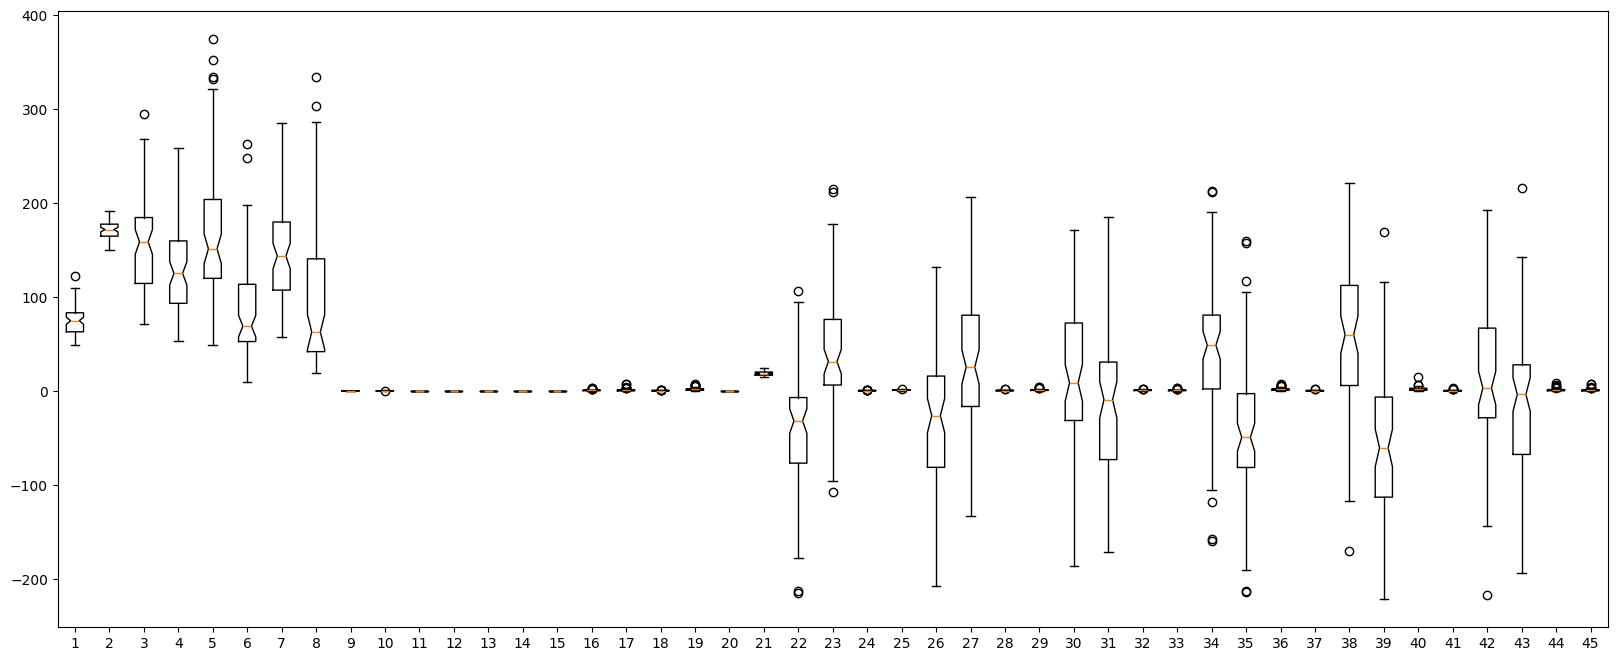

In [73]:
plt.figure(figsize=(20,8))
plt.boxplot(X_train,notch=True);
plt.show()

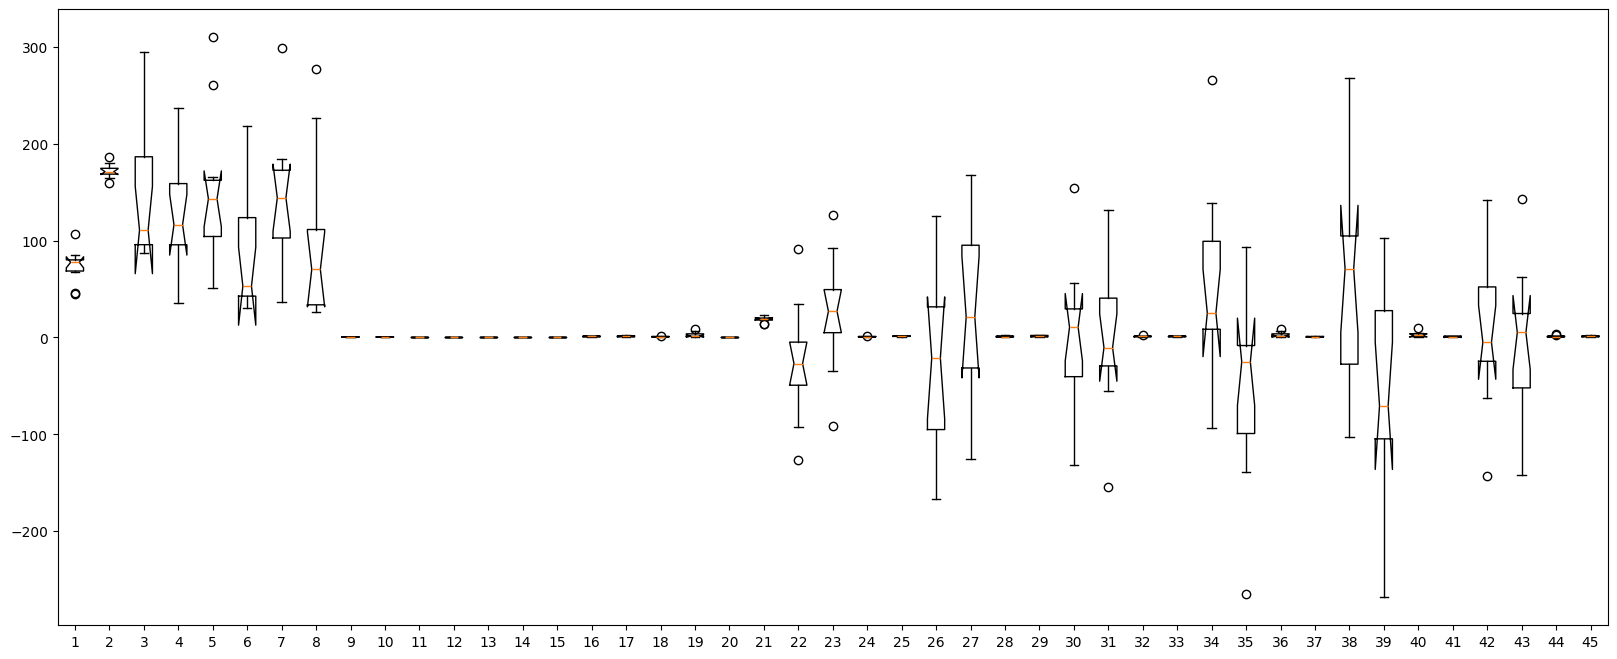

In [74]:
plt.figure(figsize=(20,8))
plt.boxplot(X_test,notch=True);
plt.show()

In [75]:
# Standardization/Normalization
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)
X_submission_test_norm = scaler.transform(X_submission_test)

In [76]:
X_train_norm

array([[-1.03854042, -1.22834375, -1.01770911, ...,  0.12710529,
        -0.27827282, -0.31532991],
       [-0.71772034, -0.16418456,  1.80033731, ...,  1.38344931,
        -0.67192652,  0.46536014],
       [ 0.11641186, -0.69626416,  0.65549112, ..., -0.66419425,
        -0.06040181, -0.46929781],
       ...,
       [-0.9743764 , -1.44117559, -1.03507957, ...,  0.18375326,
        -0.32983515, -0.26446686],
       [-1.55185254,  0.04864728, -1.17706834, ..., -0.96172952,
         1.24196718, -0.76848531],
       [-0.33273625,  0.89997463, -0.02563589, ..., -0.78945247,
         0.07733615, -0.5348161 ]])

## Training

In [77]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    #class_weight='balanced',
    #max_features='sqrt',
    random_state=42
)

In [81]:
rf.fit(X_train_norm, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

In [ ]:
y_pred = rf.predict(X_test_norm)

In [ ]:
y_pred

In [82]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

NameError: name 'y_pred' is not defined

#### Finding best parameters

In [83]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=42)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [84]:
Tree = DecisionTreeClassifier(random_state=0)
p_grid_tree = {'min_samples_split': [i for i in range(2,16)],
               'min_samples_leaf': [i for i in range(2,16)]}
grid_tree = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, scoring="accuracy", cv=5)
grid_tree.fit(X_train_norm, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test_norm,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.8714285714285713
Best params: {'min_samples_leaf': 11, 'min_samples_split': 2}
Tree test score : 0.7


In [ ]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging)
grid_bagging.fit(X_train_norm, y_train)
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test_norm,y_test))

In [ ]:

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,25,50,250,500,1000], 'min_samples_leaf': [2,5,10], 'max_features': ['sqrt','log2'], 'max_depth': [2,4,6]}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF.fit(X_train_norm, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_val_norm,y_val))

In [85]:

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [50, 75, 100, 500, 1000, 2000], 'max_features': ['sqrt','log2'], 'max_depth': [2, 4, 5, 6, 7]}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='f1_macro', cv=7)
grid_RF.fit(X_train_norm, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_val_norm,y_val))

Best Validation Score: 0.9542857142857143
Best params: {'max_depth': 2, 'max_features': 'log2', 'n_estimators': 75}
Random Forest test score : 0.9446153846153846


In [94]:
X_train_norm.shape

(70, 45)

In [95]:
grid_RF.predict(X_test_norm)

array([4, 3, 1, 1, 2, 4, 4, 3, 3, 2])

In [96]:
y_pred = grid_RF.predict(X_val_norm)

In [97]:

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3

    accuracy                           0.95        20
   macro avg       0.97      0.93      0.94        20
weighted avg       0.96      0.95      0.95        20

[[6 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 3 0]
 [1 0 0 0 2]]


In [98]:
y_submission = grid_RF.predict(X_submission_test_norm)

In [99]:
sample['Category'] = y_submission

In [100]:
sample.to_csv('predictions_more_feats.csv',index=False)

45
LV_minus_RV_ES             0.084105
LV_EF                      0.073367
MYO_minus_LV_ES            0.058150
LV_vol_ES                  0.051226
MYO_LV_ES                  0.050077
RV_LV_ED                   0.045227
MYO_minus_RV_ES            0.042493
RV_minus_LV_ES             0.041171
LV_minus_RV_ED             0.038022
RV_minus_LV_ED             0.036700
LV_vol_ED                  0.036495
RV_minus_MYO_ED            0.032281
LV_minus_MYO_ES            0.031898
LV_over_RV_ED              0.031876
RV_over_MYO_ED             0.031533
MYO_minus_LV_ED            0.031035
LV_over_RV_ES              0.029323
MYO_over_LV_ED             0.023589
RV_minus_MYO_ES            0.023404
LV_over_MYO_ES             0.022750
MYO_over_LV_ES             0.022403
RV_over_LV_ES              0.022236
MYO_LV_ED                  0.020898
LV_minus_MYO_ED            0.017157
RV_vol_ES                  0.016843
MYO_vol_ED                 0.013668
MYO_over_RV_ES             0.012838
RV_LV_ES                 

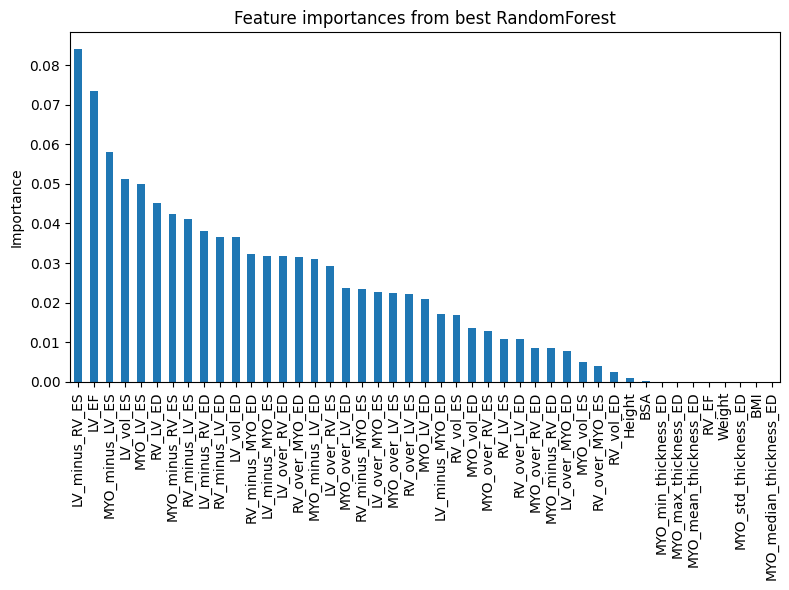

In [105]:
features = X#.drop('Id', axis=1)

# Get the best RF
best_rf = grid_RF.best_estimator_

# Extract importances
importances = best_rf.feature_importances_

# Map to feature names & sort
feat_imp = pd.Series(importances, index=features.columns)
feat_imp = feat_imp.sort_values(ascending=False)

# Display
print(len(importances))
print(feat_imp)
plt.figure(figsize=(8,6))
feat_imp.plot(kind='bar')
plt.title("Feature importances from best RandomForest")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [106]:
selected_feat = feat_imp[:12]

In [107]:
type(selected_feat)

pandas.core.series.Series

In [108]:
selected_feat.index

Index(['LV_minus_RV_ES', 'LV_EF', 'MYO_minus_LV_ES', 'LV_vol_ES', 'MYO_LV_ES',
       'RV_LV_ED', 'MYO_minus_RV_ES', 'RV_minus_LV_ES', 'LV_minus_RV_ED',
       'RV_minus_LV_ED', 'LV_vol_ED', 'RV_minus_MYO_ED'],
      dtype='object')

In [109]:
X_selected_features = X[selected_feat.index]

In [110]:
X_selected_submission_test = X_submission_test[selected_feat.index]

In [111]:
X_selected_train, X_selected_temp, y_train, y_temp = train_test_split(X_selected_features, y, test_size=0.3, stratify=y, random_state=42)

X_selected_val, X_selected_test, y_val, y_test = train_test_split(X_selected_temp, y_temp, test_size=0.33, random_state=42)


In [112]:
scaler = StandardScaler()
X_selected_train_norm = scaler.fit_transform(X_selected_train)
X_selected_val_norm = scaler.transform(X_selected_val)
X_selected_test_norm = scaler.transform(X_selected_test)
X_selected_submission_test_norm = scaler.transform(X_selected_submission_test)

In [113]:
X_selected_train_norm.shape

(70, 12)

In [114]:

RF_selected=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [50, 75, 100, 125, 150], 'max_features': ['sqrt','log2'], 'max_depth': [2, 3, 4, 5, 6]}

grid_RF_selected = GridSearchCV(estimator=RF_selected, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF_selected.fit(X_selected_train_norm, y_train)

print("Best Validation Score: {}".format(grid_RF_selected.best_score_))
print("Best params: {}".format(grid_RF_selected.best_params_))
print("Random Forest test score :",grid_RF_selected.score(X_selected_val_norm,y_val))

Best Validation Score: 0.9571428571428571
Best params: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 125}
Random Forest test score : 0.85


In [115]:
y_pred_selected = grid_RF_selected.predict(X_selected_val_norm)

In [116]:
print(classification_report(y_val, y_pred_selected))
print(confusion_matrix(y_val, y_pred_selected))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.80      1.00      0.89         4
           2       1.00      0.75      0.86         4
           3       1.00      0.67      0.80         3
           4       1.00      0.67      0.80         3

    accuracy                           0.85        20
   macro avg       0.91      0.82      0.84        20
weighted avg       0.89      0.85      0.85        20

[[6 0 0 0 0]
 [0 4 0 0 0]
 [0 1 3 0 0]
 [1 0 0 2 0]
 [1 0 0 0 2]]


In [117]:
y_selected_submission = grid_RF_selected.predict(X_selected_submission_test_norm)

In [118]:
sample['Category'] = y_selected_submission

In [119]:
sample.to_csv('predictions_selected_feats.csv',index=False)

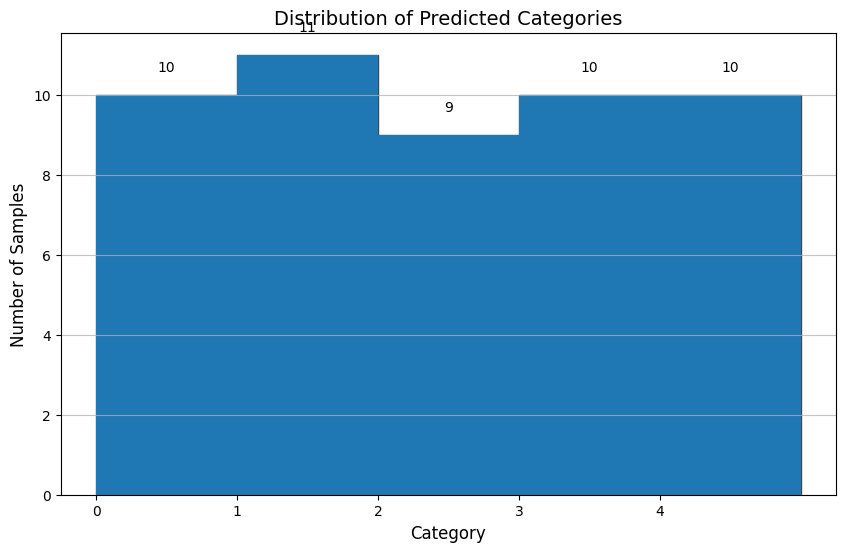

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('predictions_more_feats.csv')

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Category'], 
         bins=5, 
         range=(0, 5), 
         edgecolor='black', 
         alpha=0.7,
         color='skyblue')

# Formatting
plt.title('Distribution of Predicted Categories', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks([0, 1, 2, 3, 4])
plt.grid(axis='y', alpha=0.75)

# Add value labels
counts, bins, patches = plt.hist(df['Category'], bins=5, range=(0, 5))
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width()/2, 
             count + 0.5, 
             str(int(count)),
             ha='center', 
             va='bottom')

plt.show()

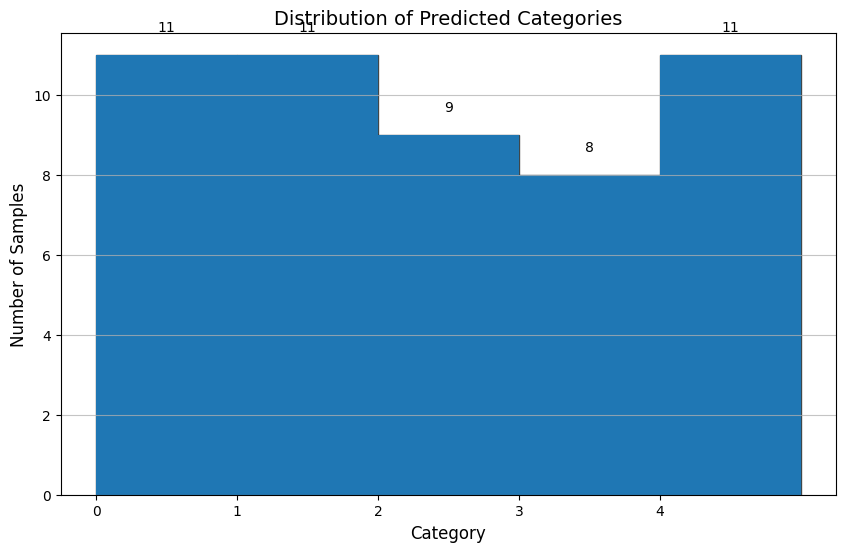

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('predictions_selected_feats.csv')

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Category'], 
         bins=5, 
         range=(0, 5), 
         edgecolor='black', 
         alpha=0.7,
         color='skyblue')

# Formatting
plt.title('Distribution of Predicted Categories', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks([0, 1, 2, 3, 4])
plt.grid(axis='y', alpha=0.75)

# Add value labels
counts, bins, patches = plt.hist(df['Category'], bins=5, range=(0, 5))
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width()/2, 
             count + 0.5, 
             str(int(count)),
             ha='center', 
             va='bottom')

plt.show()